In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#import data
df = pd.read_csv('data/Recidivism_Data_cleaned.csv')
df_original = df.copy()


In [2]:
# We only want to predict recidivism within 3 years
#We are also looking at just Males
df.drop(['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Gender'], axis=1, inplace=True)

# Remove variables thaat are determined only after prison release
df.drop(['Supervision_Risk_Score_First', 'Supervision_Level_First',
         'Violations_ElectronicMonitoring', 'Violations_FailToReport','Violations_FailToReport', 'Violations_MoveWithoutPermission',
         'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 
         'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive','DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 
         'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt'], axis=1, inplace=True)

### Data Preprocessing

In [3]:
#Chance all Booleans to Integers
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Dummy Variable for Race 
df['Race'] = df['Race'].map({'BLACK': 1, 'WHITE': 0})

# Change age to integer as opposed to float
df['Age_at_Release'] = df['Age_at_Release'].astype(int)

# Interger Encoded to for embeddings in NN
df['Prison_Offense'] = df['Prison_Offense'].map({category: idx for idx, category in enumerate(df['Prison_Offense'].unique())})
df['Education_Level'] = df['Education_Level'].map({'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2})

# Make Recidivism_Within_3years the last column
cols = [col for col in df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
df = df[cols]

In [4]:
# Variables to normalize
columns_to_normalize = ['Age_at_Release', 'Prison_Years']  # add other columns here

# Apply Standardization
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

#Split Train and Test Data
train_df = df[df['Training_Sample'] == 1]
test_df = df[df['Training_Sample'] == 0]
train_df = train_df.drop(columns=['Training_Sample'])
test_df = test_df.drop(columns=['Training_Sample'])

### MLP

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [6]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [7]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(train_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(31, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [9]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [10]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [11]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 10/10 [00:00<00:00, 562.58it/s]


Epoch: 1 Train Loss: 0.6545899078217776 Val Loss: 0.62260952576819 Val Acc: 0.657672849915683


100%|██████████| 10/10 [00:00<00:00, 545.05it/s]


Epoch: 2 Train Loss: 0.615823891392793 Val Loss: 0.5937818671760431 Val Acc: 0.6884485666104553


100%|██████████| 10/10 [00:00<00:00, 474.79it/s]


Epoch: 3 Train Loss: 0.6036770100110662 Val Loss: 0.5860638877794674 Val Acc: 0.6930860033726813


100%|██████████| 10/10 [00:00<00:00, 547.91it/s]


Epoch: 4 Train Loss: 0.5982559267560396 Val Loss: 0.5829176081573783 Val Acc: 0.7015177065767285


100%|██████████| 10/10 [00:00<00:00, 574.11it/s]


Epoch: 5 Train Loss: 0.5950767238967359 Val Loss: 0.5790067640766124 Val Acc: 0.698566610455312


100%|██████████| 10/10 [00:00<00:00, 517.09it/s]


Epoch: 6 Train Loss: 0.5935052493488038 Val Loss: 0.5779997909451013 Val Acc: 0.7086846543001686


100%|██████████| 10/10 [00:00<00:00, 566.56it/s]


Epoch: 7 Train Loss: 0.5914416414293933 Val Loss: 0.5780911787364374 Val Acc: 0.7048903878583473


100%|██████████| 10/10 [00:00<00:00, 568.23it/s]


Epoch: 8 Train Loss: 0.5908242636550457 Val Loss: 0.5815419016961907 Val Acc: 0.6977234401349073


100%|██████████| 10/10 [00:00<00:00, 584.29it/s]


Epoch: 9 Train Loss: 0.5905154591688346 Val Loss: 0.5760636323620055 Val Acc: 0.7065767284991569


100%|██████████| 10/10 [00:00<00:00, 499.20it/s]


Epoch: 10 Train Loss: 0.5891067442177963 Val Loss: 0.5762656761261102 Val Acc: 0.704468802698145


100%|██████████| 10/10 [00:00<00:00, 572.05it/s]


Epoch: 11 Train Loss: 0.588857774605344 Val Loss: 0.5735794505823724 Val Acc: 0.7082630691399663


100%|██████████| 10/10 [00:00<00:00, 570.28it/s]


Epoch: 12 Train Loss: 0.5870473150102073 Val Loss: 0.5785243524266737 Val Acc: 0.7019392917369308


100%|██████████| 10/10 [00:00<00:00, 520.45it/s]


Epoch: 13 Train Loss: 0.5858069941954773 Val Loss: 0.5737909104731593 Val Acc: 0.7057335581787522


100%|██████████| 10/10 [00:00<00:00, 564.81it/s]


Epoch: 14 Train Loss: 0.5851049801229818 Val Loss: 0.5745324267303763 Val Acc: 0.7023608768971332


100%|██████████| 10/10 [00:00<00:00, 550.87it/s]

Epoch: 15 Train Loss: 0.5840611501378365 Val Loss: 0.5754894655430297 Val Acc: 0.6960370994940978


In [13]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []
    all_probs = []  # To store probability estimates

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(torch.sigmoid(out).cpu().numpy())  # Store probability estimates

    acc = total_correct / total_num
    return acc, all_preds, all_targets, all_probs  # Return probability estimates

test_acc, all_preds, all_targets, all_probs = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 69.61%


In [14]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

In [15]:
from sklearn.metrics import brier_score_loss

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

# Calculate the Brier Score using probability estimates
test_acc, _, _, all_probs = test_accuracy(model, test_loader)
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score on Test Set: {brier_score:.4f}")

ROC AUC Score on Test Set: 0.7448
Brier Score on Test Set: 0.1985


In [17]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)  # Use total_train_loader
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

# After training, evaluate on the test set
test_acc, all_preds, all_targets, all_probs = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


100%|██████████| 10/10 [00:00<00:00, 543.94it/s]


Epoch: 1 Train Loss: 0.5701497789767095 Val Loss: 0.5605200602473537 Val Acc: 0.7133220910623946


100%|██████████| 10/10 [00:00<00:00, 583.73it/s]


Epoch: 2 Train Loss: 0.5692620015779186 Val Loss: 0.5550466916613394 Val Acc: 0.7188026981450253


100%|██████████| 10/10 [00:00<00:00, 560.03it/s]


Epoch: 3 Train Loss: 0.5684008397320764 Val Loss: 0.5538211610626812 Val Acc: 0.7204890387858347


100%|██████████| 10/10 [00:00<00:00, 512.41it/s]


Epoch: 4 Train Loss: 0.5674579834570115 Val Loss: 0.5530990830561363 Val Acc: 0.7225969645868465


100%|██████████| 10/10 [00:00<00:00, 572.54it/s]


Epoch: 5 Train Loss: 0.5669258823280776 Val Loss: 0.5516163542942092 Val Acc: 0.7217537942664418


100%|██████████| 10/10 [00:00<00:00, 569.05it/s]


Epoch: 6 Train Loss: 0.5657628063089172 Val Loss: 0.5510452958624842 Val Acc: 0.7251264755480608


100%|██████████| 10/10 [00:00<00:00, 524.39it/s]


Epoch: 7 Train Loss: 0.5645869630698453 Val Loss: 0.5517455936483348 Val Acc: 0.7217537942664418


100%|██████████| 10/10 [00:00<00:00, 571.07it/s]


Epoch: 8 Train Loss: 0.5640584001255536 Val Loss: 0.5507569519102473 Val Acc: 0.7204890387858347


100%|██████████| 10/10 [00:00<00:00, 574.97it/s]


Epoch: 9 Train Loss: 0.5632097957844632 Val Loss: 0.5479835434667578 Val Acc: 0.7272344013490725


100%|██████████| 10/10 [00:00<00:00, 475.74it/s]


Epoch: 10 Train Loss: 0.5639667852758329 Val Loss: 0.5475742127400828 Val Acc: 0.7204890387858347


100%|██████████| 10/10 [00:00<00:00, 564.27it/s]


Epoch: 11 Train Loss: 0.561844787895623 Val Loss: 0.5477325807735449 Val Acc: 0.7225969645868465


100%|██████████| 10/10 [00:00<00:00, 518.19it/s]


Epoch: 12 Train Loss: 0.5624257437637413 Val Loss: 0.545435880830678 Val Acc: 0.7221753794266442


100%|██████████| 10/10 [00:00<00:00, 477.52it/s]


Epoch: 13 Train Loss: 0.5602739465454559 Val Loss: 0.5438731975137283 Val Acc: 0.7276559865092749


100%|██████████| 10/10 [00:00<00:00, 583.36it/s]


Epoch: 14 Train Loss: 0.5590830655984925 Val Loss: 0.5450694376059366 Val Acc: 0.71964586846543


100%|██████████| 10/10 [00:00<00:00, 570.23it/s]


Epoch: 15 Train Loss: 0.5580706781397342 Val Loss: 0.547989717120867 Val Acc: 0.7141652613827993
Test Accuracy: 71.10%


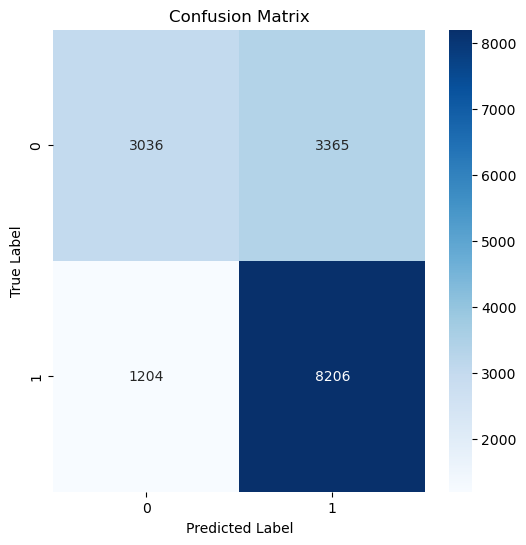

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [19]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

ROC AUC Score on Test Set: 0.7720
